In [0]:
import sklearn
from sklearn import datasets

import matplotlib.pyplot as plt
import numpy as np

import math
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.notebook import tqdm

USE_GPU = True

torch_device = torch.device('cpu')
if USE_GPU:
    torch_device = torch.device('cuda')
    
torch_dtype = torch.float

In [0]:
def show_performance(Y_train, Y_train_pred, Y_test, Y_test_pred):
    Y_train = Y_train.cpu()
    Y_train_pred = Y_train_pred.cpu()
    Y_test = Y_test.cpu()
    Y_test_pred = Y_test_pred.cpu()
    acc_train = (Y_train==Y_train_pred).sum().item() / Y_train.size()[0]
    acc_test = (Y_test==Y_test_pred).sum().item() / Y_test.size()[0]

    print('Training accuracy: ', acc_train)
    print('Testing accuracy: ', acc_test)

    %matplotlib inline
    plt.subplot(2, 3, 1)
    plt.hist(Y_train_pred, color='b', bins=10)
    plt.title('Training set predictions')
    plt.xlabel('none')

    plt.subplot(2, 3, 2)
    plt.hist(Y_train, color='r', bins=10)
    plt.title('Training set actual')

    plt.subplot(2, 3, 3)
    plt.imshow(confusion_matrix(Y_train, Y_train_pred))
    plt.colorbar()
    plt.title('Training Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    

    plt.subplot(2, 3, 4)
    plt.hist(Y_test_pred, color='b', bins=10)
    plt.title('Testing set predictions')

    plt.subplot(2, 3, 5)
    plt.hist(Y_test, color='r', bins=10)
    plt.title('Testing set actual')

    plt.subplot(2, 3, 6)
    plt.imshow(confusion_matrix(Y_test, Y_test_pred))
    plt.colorbar()
    plt.title('Testing Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.show()

# MNIST DATASET

In [0]:
mnist_dataset = datasets.fetch_openml('mnist_784', version=1)

In [4]:
X = mnist_dataset['data'].reshape((-1, 1, 28, 28))/255.
Y = np.array(list(map(int, mnist_dataset['target'])))

X = torch.from_numpy(X).type(torch_dtype).to(torch_device)
Y = torch.from_numpy(Y).type(torch.long).to(torch_device)

print(X.shape)
print(Y.shape)

X_train = X[:60000]
Y_train = Y[:60000]

X_test = X[60000:]
Y_test = Y[60000:]

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

del mnist_dataset

torch.Size([70000, 1, 28, 28])
torch.Size([70000])
torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


### MNIST Images

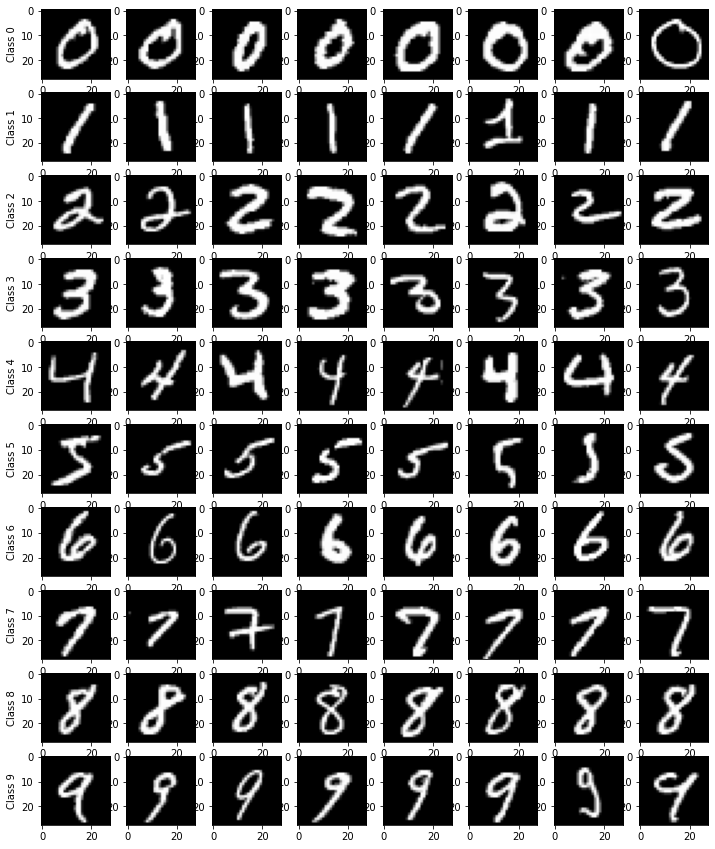

In [7]:
%matplotlib inline

rows = 10
cols = 8

fig, axs = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
for y in range(rows):
    imgs = X[Y==y]
    for x in range(cols):
        img = imgs[x].cpu().numpy()
        axs[y, x].imshow(img[0], cmap='gray')
    axs[y, 0].set_ylabel(f'Class {y}')
fig.show()

In [0]:
class MnistNet(nn.Module):
    def __init__(self):
        super(MnistNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=0.01, momentum=0.9)

    def forward(self, x):
        # b, 1, 28, 28
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # b, 6, 14, 14
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # b, 16, 7, 7
        x = x.view(-1, 16 * 7 * 7)
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x
    
    
    
    def fit(self, X, Y, epochs=1, batch_size=32):
        for epoch in range(epochs):
            print(f'Epoch {epoch}\n--------------------------------')
            running_loss = 0.0
            batch_pbar = tqdm(range(int(math.ceil(X_train.shape[0]/batch_size))))
            for batch_i in batch_pbar:
                X_batch = X[batch_i*batch_size: (batch_i+1)*batch_size]
                Y_batch = Y[batch_i*batch_size: (batch_i+1)*batch_size]

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                Y_batch_pred = self(X_batch)
                loss = self.criterion(Y_batch_pred, Y_batch)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()
                if batch_i % 100 == 0 and batch_i != 0:    # print every 100 mini-batches
#                     batch_pbar.set_description(f'100 Batch Loss: {running_loss}')
                    print(f'100 Batch Loss: {running_loss}')
                    running_loss = 0.0


mnist_net = MnistNet().type(torch_dtype).to(torch_device)

Training accuracy:  0.029333333333333333
Testing accuracy:  0.0251


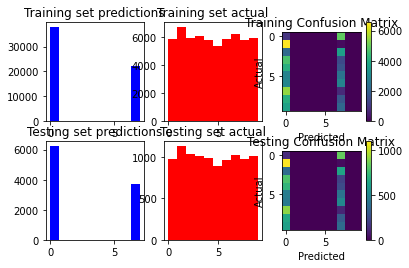

In [6]:
Y_train_pred = mnist_net.forward(X_train).detach().argmax(axis=1)
Y_test_pred = mnist_net.forward(X_test).detach().argmax(axis=1)
show_performance(Y_train, Y_train_pred, Y_test, Y_test_pred)

In [7]:
mnist_net.fit(X_train, Y_train, epochs=10)

Epoch 0
--------------------------------


100 Batch Loss: 232.55094480514526
100 Batch Loss: 230.193035364151
100 Batch Loss: 230.13984608650208
100 Batch Loss: 230.02427291870117
100 Batch Loss: 229.86395931243896
100 Batch Loss: 229.44513869285583
100 Batch Loss: 224.62885117530823
100 Batch Loss: 199.9929474592209
100 Batch Loss: 186.46468472480774
100 Batch Loss: 178.54278481006622
100 Batch Loss: 176.17425763607025
100 Batch Loss: 174.67718410491943
100 Batch Loss: 173.1050899028778
100 Batch Loss: 171.74064016342163
100 Batch Loss: 173.39466643333435
100 Batch Loss: 173.54515612125397
100 Batch Loss: 171.87242770195007
100 Batch Loss: 170.56084418296814

Epoch 1
--------------------------------


100 Batch Loss: 170.86328959465027
100 Batch Loss: 170.44695150852203
100 Batch Loss: 170.12413907051086
100 Batch Loss: 169.30860435962677
100 Batch Loss: 164.53623616695404
100 Batch Loss: 161.76807308197021
100 Batch Loss: 159.7859103679657
100 Batch Loss: 161.1815756559372
100 Batch Loss: 160.66459703445435
100 Batch Loss: 161.22689247131348
100 Batch Loss: 160.17793238162994
100 Batch Loss: 160.0208044052124
100 Batch Loss: 157.43209874629974
100 Batch Loss: 154.35183608531952
100 Batch Loss: 153.1151932477951
100 Batch Loss: 152.3496594429016
100 Batch Loss: 152.08668279647827
100 Batch Loss: 150.54731011390686

Epoch 2
--------------------------------


100 Batch Loss: 151.94967830181122
100 Batch Loss: 150.65315508842468
100 Batch Loss: 151.91696500778198
100 Batch Loss: 150.50086665153503
100 Batch Loss: 150.94569885730743
100 Batch Loss: 150.20134150981903
100 Batch Loss: 149.8707938194275
100 Batch Loss: 150.1209715604782
100 Batch Loss: 150.25521552562714
100 Batch Loss: 151.04822647571564
100 Batch Loss: 149.64885067939758
100 Batch Loss: 150.110236287117
100 Batch Loss: 150.1339614391327
100 Batch Loss: 150.26585590839386
100 Batch Loss: 150.42520928382874
100 Batch Loss: 149.9256328344345
100 Batch Loss: 149.43895423412323
100 Batch Loss: 149.13012981414795

Epoch 3
--------------------------------


100 Batch Loss: 150.31302070617676
100 Batch Loss: 149.03230249881744
100 Batch Loss: 150.46967041492462
100 Batch Loss: 149.71852898597717
100 Batch Loss: 149.56798005104065
100 Batch Loss: 148.9373710155487
100 Batch Loss: 149.01841735839844
100 Batch Loss: 148.50546252727509
100 Batch Loss: 149.1560959815979
100 Batch Loss: 149.04252910614014
100 Batch Loss: 148.61439216136932
100 Batch Loss: 149.12172174453735
100 Batch Loss: 148.96090817451477
100 Batch Loss: 149.56526637077332
100 Batch Loss: 149.52069294452667
100 Batch Loss: 149.16261875629425
100 Batch Loss: 148.89984440803528
100 Batch Loss: 148.50515389442444

Epoch 4
--------------------------------


100 Batch Loss: 150.11501836776733
100 Batch Loss: 148.57828772068024
100 Batch Loss: 149.4779975414276
100 Batch Loss: 149.7083226442337
100 Batch Loss: 148.89392793178558
100 Batch Loss: 148.29851305484772
100 Batch Loss: 148.69049453735352
100 Batch Loss: 148.34533822536469
100 Batch Loss: 149.5176055431366
100 Batch Loss: 148.83285748958588
100 Batch Loss: 148.5505462884903
100 Batch Loss: 148.74632620811462
100 Batch Loss: 148.60912775993347
100 Batch Loss: 148.8533263206482
100 Batch Loss: 149.31131064891815
100 Batch Loss: 149.0158268213272
100 Batch Loss: 148.53995871543884
100 Batch Loss: 148.48812079429626

Epoch 5
--------------------------------


100 Batch Loss: 149.69456613063812
100 Batch Loss: 148.41430282592773
100 Batch Loss: 148.81882774829865
100 Batch Loss: 149.6539752483368
100 Batch Loss: 148.64969098567963
100 Batch Loss: 147.9636710882187
100 Batch Loss: 148.33458697795868
100 Batch Loss: 147.823056101799
100 Batch Loss: 148.32901287078857
100 Batch Loss: 148.57377433776855
100 Batch Loss: 148.0483478307724
100 Batch Loss: 148.36628997325897
100 Batch Loss: 148.40294361114502
100 Batch Loss: 148.63538646697998
100 Batch Loss: 148.91930878162384
100 Batch Loss: 148.07708954811096
100 Batch Loss: 148.03357076644897
100 Batch Loss: 147.8517541885376

Epoch 6
--------------------------------


100 Batch Loss: 149.36939477920532
100 Batch Loss: 148.1684889793396
100 Batch Loss: 148.6357865333557
100 Batch Loss: 148.86643409729004
100 Batch Loss: 148.55073237419128
100 Batch Loss: 148.11449801921844
100 Batch Loss: 148.05608677864075
100 Batch Loss: 147.75123941898346
100 Batch Loss: 148.19924366474152
100 Batch Loss: 148.0069637298584
100 Batch Loss: 148.06815767288208
100 Batch Loss: 148.05562150478363
100 Batch Loss: 148.58732771873474
100 Batch Loss: 148.14936530590057
100 Batch Loss: 148.55057668685913
100 Batch Loss: 148.11912035942078
100 Batch Loss: 147.95304667949677
100 Batch Loss: 147.70814979076385

Epoch 7
--------------------------------


100 Batch Loss: 149.61235570907593
100 Batch Loss: 147.805690407753
100 Batch Loss: 148.70255410671234
100 Batch Loss: 148.2651081085205
100 Batch Loss: 147.88922727108002
100 Batch Loss: 147.81752061843872
100 Batch Loss: 147.54416847229004
100 Batch Loss: 147.455219745636
100 Batch Loss: 148.21693170070648
100 Batch Loss: 148.67665362358093
100 Batch Loss: 147.76329469680786
100 Batch Loss: 148.08628821372986
100 Batch Loss: 148.3777562379837
100 Batch Loss: 148.16609728336334
100 Batch Loss: 148.52223789691925
100 Batch Loss: 148.09883105754852
100 Batch Loss: 147.79021060466766
100 Batch Loss: 147.69383680820465

Epoch 8
--------------------------------


100 Batch Loss: 149.36427187919617
100 Batch Loss: 147.8008612394333
100 Batch Loss: 148.4049243927002
100 Batch Loss: 148.44834923744202
100 Batch Loss: 147.65848219394684
100 Batch Loss: 147.49771082401276
100 Batch Loss: 147.69654178619385
100 Batch Loss: 147.37572193145752
100 Batch Loss: 148.02568173408508
100 Batch Loss: 147.82169139385223
100 Batch Loss: 147.63400149345398
100 Batch Loss: 147.81905114650726
100 Batch Loss: 148.0247664451599
100 Batch Loss: 147.84372985363007
100 Batch Loss: 148.0077178478241
100 Batch Loss: 147.78392446041107
100 Batch Loss: 147.9011628627777
100 Batch Loss: 147.71873199939728

Epoch 9
--------------------------------


100 Batch Loss: 149.1874701976776
100 Batch Loss: 147.60833477973938
100 Batch Loss: 148.08533251285553
100 Batch Loss: 148.15061855316162
100 Batch Loss: 147.6786699295044
100 Batch Loss: 147.4723435640335
100 Batch Loss: 147.50951313972473
100 Batch Loss: 147.34213376045227
100 Batch Loss: 147.6919628381729
100 Batch Loss: 147.50471830368042
100 Batch Loss: 147.6597969532013
100 Batch Loss: 148.29595386981964
100 Batch Loss: 147.71084916591644
100 Batch Loss: 147.69452476501465
100 Batch Loss: 148.1995564699173
100 Batch Loss: 147.76205503940582
100 Batch Loss: 147.7662537097931
100 Batch Loss: 147.49519073963165



Training accuracy:  0.9815666666666667
Testing accuracy:  0.981


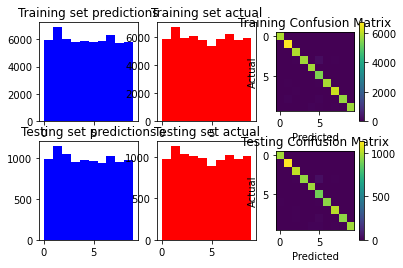

In [8]:
Y_train_pred = mnist_net.forward(X_train).detach().argmax(axis=1)
Y_test_pred = mnist_net.forward(X_test).detach().argmax(axis=1)
show_performance(Y_train, Y_train_pred, Y_test, Y_test_pred)

# CIFAR 10 DATASET

In [0]:
cifar10_dataset = datasets.fetch_openml('CIFAR_10')

In [5]:
X = cifar10_dataset['data'].reshape((-1, 3, 32, 32))/255.
Y = np.array(list(map(int, cifar10_dataset['target'])))

X = np.rot90(X, 1, axes=(2, 3))

X = torch.from_numpy(X.copy()).type(torch_dtype).to(torch_device)
Y = torch.from_numpy(Y).type(torch.long).to(torch_device)

print(X.shape)
print(Y.shape)

X_train = X[:50000]
Y_train = Y[:50000]

X_test = X[50000:]
Y_test = Y[50000:]

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

del cifar10_dataset
del X
del Y

torch.Size([60000, 3, 32, 32])
torch.Size([60000])
torch.Size([50000, 3, 32, 32])
torch.Size([50000])
torch.Size([10000, 3, 32, 32])
torch.Size([10000])


## CIFAR-10 Images

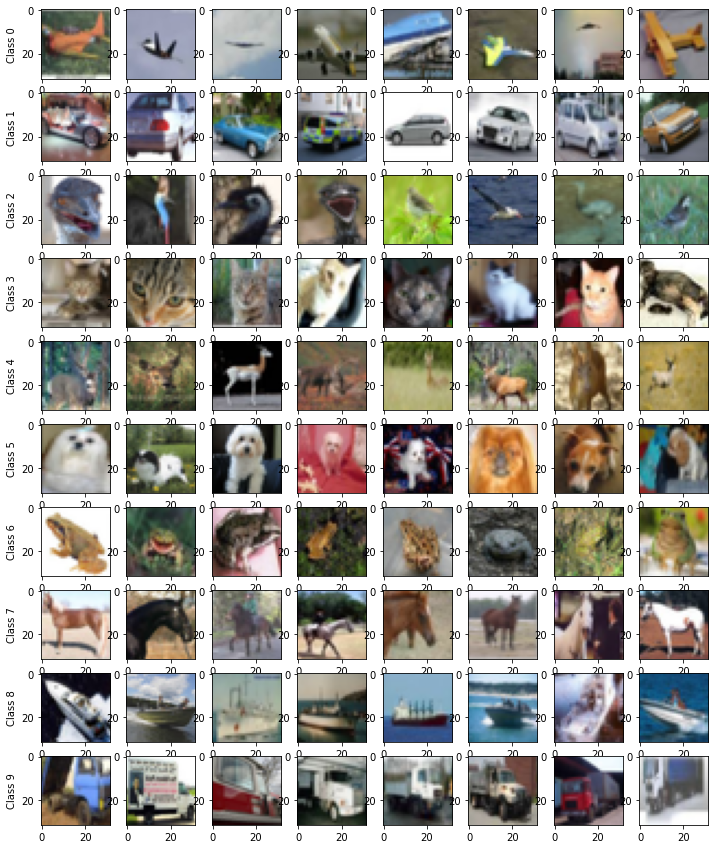

In [15]:
%matplotlib inline

rows = 10
cols = 8

fig, axs = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
for y in range(rows):
    imgs = X[Y==y]
    for x in range(cols):
        img = imgs[x].cpu().numpy()
        axs[y, x].imshow(img.swapaxes(0,-1))
    axs[y, 0].set_ylabel(f'Class {y}')
fig.show()

In [0]:
class Cifar10Net(nn.Module):
    def __init__(self, lr=0.01, momentum=0.9):
        super(Cifar10Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(16 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=lr, momentum=momentum)

    def forward(self, x):
        # b, 3, 32, 32
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        # x = F.dropout(x, p=0.2)
        
        # b, 6, 16, 16
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        # x = F.dropout(x, p=0.2)
        
        # b, 16, 8, 8
        x = x.view(-1, 16 * 8 * 8)
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x
    
    
    
    def fit(self, X_train, Y_train, X_test, Y_test, epochs=1, batch_size=100, pbar=True):
        losses_train, losses_test = [], []
        for epoch in range(epochs):
            if pbar:
                print(f'Epoch {epoch}\n--------------------------------')
            running_loss = 0.0
            
            batch_pbar = range(math.ceil(X_train.shape[0]//batch_size))
            if pbar:
                batch_pbar = tqdm(batch_pbar)
            
            for batch_i in batch_pbar:
                gc.collect()
                X_batch = X_train[batch_i*batch_size: (batch_i+1)*batch_size]
                Y_batch = Y_train[batch_i*batch_size: (batch_i+1)*batch_size]

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                Y_batch_pred = self(X_batch)
                loss = self.criterion(Y_batch_pred, Y_batch)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()
                if batch_i % 100 == 0 and pbar:    # print every 100 mini-batches
                    batch_pbar.set_postfix({'100 Batch Loss':running_loss})
                    running_loss = 0.0
            Y_train_pred = self.forward(X_train[:1000])
            Y_test_pred = self.forward(X_test[:1000])
            loss_train = self.criterion(Y_train_pred, Y_train[:1000])
            loss_test = self.criterion(Y_test_pred, Y_test[:1000])
            losses_train.append(loss_train.cpu().detach())
            losses_test.append(loss_test.cpu().detach())
        return losses_train, losses_test

In [0]:
cifar10_net = Cifar10Net().type(torch_dtype).to(torch_device)

Training accuracy:  0.134
Testing accuracy:  0.098


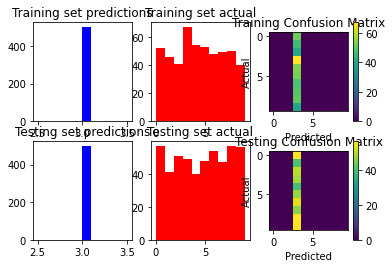

In [102]:
gc.collect()
Y_train_pred = cifar10_net.forward(X_train[:500]).detach().argmax(axis=1)
Y_test_pred = cifar10_net.forward(X_test[:500]).detach().argmax(axis=1)
show_performance(Y_train[:500], Y_train_pred, Y_test[:500], Y_test_pred)

In [103]:
losses_train, losses_test = cifar10_net.fit(X_train, Y_train, X_test, Y_test, epochs=20, pbar=True)

Epoch 0
--------------------------------



Epoch 1
--------------------------------



Epoch 2
--------------------------------



Epoch 3
--------------------------------



Epoch 4
--------------------------------



Epoch 5
--------------------------------



Epoch 6
--------------------------------



Epoch 7
--------------------------------



Epoch 8
--------------------------------



Epoch 9
--------------------------------



Epoch 10
--------------------------------



Epoch 11
--------------------------------



Epoch 12
--------------------------------



Epoch 13
--------------------------------



Epoch 14
--------------------------------



Epoch 15
--------------------------------



Epoch 16
--------------------------------



Epoch 17
--------------------------------



Epoch 18
--------------------------------



Epoch 19
--------------------------------


Training accuracy:  0.503
Testing accuracy:  0.4824


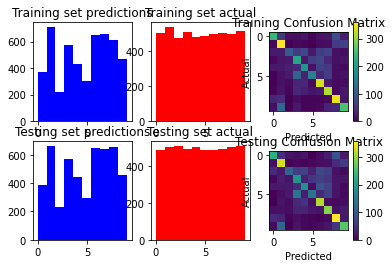

In [104]:
gc.collect()
Y_train_pred = cifar10_net.forward(X_train[:5000]).detach().argmax(axis=1)
Y_test_pred = cifar10_net.forward(X_test[:5000]).detach().argmax(axis=1)
show_performance(Y_train[:5000], Y_train_pred, Y_test[:5000], Y_test_pred)

In [0]:
def run_for(lr, momentum, epochs, ax):
    cifar10_net = Cifar10Net(lr, momentum).type(torch_dtype).to(torch_device)
    losses_train, losses_test = cifar10_net.fit(X_train, Y_train, X_test, Y_test, epochs=epochs, pbar=True)
    train_line = ax.plot(np.arange(len(losses_train)), losses_train, c='b', label='Training Loss')
    test_line = ax.plot(np.arange(len(losses_test)), losses_test, c='g', label='Testing Loss')
    ax.legend()
    ax.set_xlim(-1, epochs)
    ax.set_ylim(0, 3)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    
    ax.set_title(f'LR = {lr}, M = {momentum}')

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
run_for(0.1, 0.4, 5, ax)

Epoch 0
--------------------------------


Epoch 0
--------------------------------



Epoch 1
--------------------------------



Epoch 2
--------------------------------



Epoch 3
--------------------------------


KeyboardInterrupt: ignored

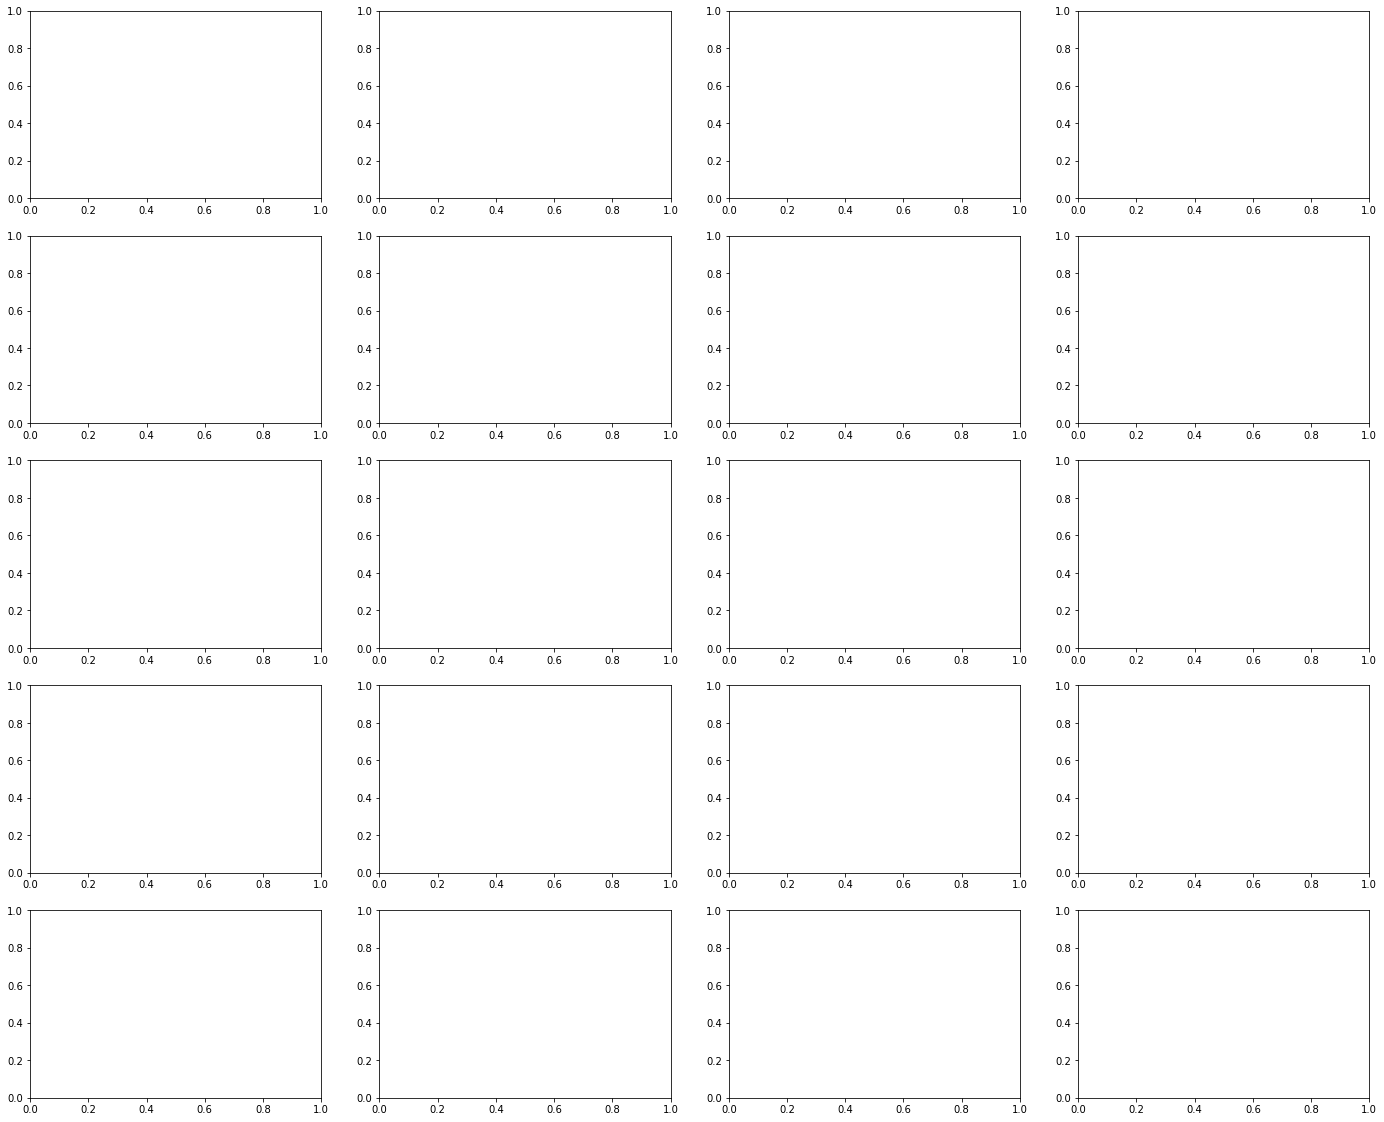

In [10]:
import gc
momentums = [0, 0.2, 0.5, 0.8, 1.0]
lrs = [0.0001, 0.001, 0.01, 0.1]


fig, axs = plt.subplots(len(momentums), len(lrs), figsize=(len(lrs)*6, len(momentums)*4))

total_bar = tqdm(range(len(momentums) * len(lrs)))
for mi, momentum in enumerate(momentums):
    for lri, lr in enumerate(lrs):
        run_for(lr, momentum, 5, axs[mi, lri])
        total_bar.update(1)

total_bar.close()

fig.suptitle('Training and Testing Loss vs Epochs with Different Learning Rates and Momentums',y=1.02)
fig.tight_layout()
fig.show()

In [0]:
class Cifar10NetBest(nn.Module):
    def __init__(self, lr=0.01, momentum=0.9):
        super(Cifar10NetBest, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.Softmax(dim=-1)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=1)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), padding=1)

        self.lin1 = nn.Linear(128*4*4, 128)
        self.lin2 = nn.Linear(128, 10)
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=lr, momentum=momentum)

    def forward(self, x):



        # model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
        # model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        # model.add(MaxPooling2D((2, 2)))
        # model.add(Dropout(0.2))
        # model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        # model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        # model.add(MaxPooling2D((2, 2)))
        # model.add(Dropout(0.2))
        # model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        # model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        # model.add(MaxPooling2D((2, 2)))
        # model.add(Dropout(0.2))
        # model.add(Flatten())
        # model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        # model.add(Dropout(0.2))
        # model.add(Dense(10, activation='softmax'))
        
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout(x)
        
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = x.view(-1, 128*4*4)
        
        x = self.relu(self.lin1(x))
        x = self.dropout(x)
        x = self.relu(self.lin2(x))
        x = self.softmax(x)

        return x
    
    def fit(self, X_train, Y_train, X_test, Y_test, epochs=1, batch_size=100, pbar=True):
        losses_train, losses_test = [], []
        for epoch in range(epochs):
            gc.collect()
            if pbar:
                print(f'Epoch {epoch}\n--------------------------------')
            running_loss = 0.0
            
            batch_pbar = range(math.ceil(X_train.shape[0]//batch_size))
            if pbar:
                batch_pbar = tqdm(batch_pbar)
            
            for batch_i in batch_pbar:
                X_batch = X_train[batch_i*batch_size: (batch_i+1)*batch_size]
                Y_batch = Y_train[batch_i*batch_size: (batch_i+1)*batch_size]

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                Y_batch_pred = self(X_batch)
                loss = self.criterion(Y_batch_pred, Y_batch)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()
                if batch_i % 100 == 0 and pbar:    # print every 100 mini-batches
                    batch_pbar.set_postfix({'100 Batch Loss':running_loss})
                    running_loss = 0.0
            Y_train_pred = self.forward(X_train[:100]).detach()
            Y_test_pred = self.forward(X_test[:100]).detach()
            loss_train = self.criterion(Y_train_pred, Y_train[:100])
            loss_test = self.criterion(Y_test_pred, Y_test[:100])
            losses_train.append(loss_train.cpu().detach())
            losses_test.append(loss_test.cpu().detach())
        gc.collect()
        return losses_train, losses_test

In [0]:
cifar_net = Cifar10NetBest().type(torch_dtype).to(torch_device)

In [44]:
cifar_net.fit(X_train, Y_train, X_test, Y_test, epochs=50, pbar=True)

Epoch 0
--------------------------------



Epoch 1
--------------------------------



Epoch 2
--------------------------------



Epoch 3
--------------------------------



Epoch 4
--------------------------------



Epoch 5
--------------------------------



Epoch 6
--------------------------------



Epoch 7
--------------------------------



Epoch 8
--------------------------------



Epoch 9
--------------------------------



Epoch 10
--------------------------------



Epoch 11
--------------------------------



Epoch 12
--------------------------------



Epoch 13
--------------------------------



Epoch 14
--------------------------------



Epoch 15
--------------------------------



Epoch 16
--------------------------------



Epoch 17
--------------------------------



Epoch 18
--------------------------------



Epoch 19
--------------------------------



Epoch 20
--------------------------------



Epoch 21
--------------------------------



Epoch 22
--------------------------------



Epoch 23
--------------------------------



Epoch 24
--------------------------------



Epoch 25
--------------------------------



Epoch 26
--------------------------------



Epoch 27
--------------------------------



Epoch 28
--------------------------------



Epoch 29
--------------------------------



Epoch 30
--------------------------------



Epoch 31
--------------------------------



Epoch 32
--------------------------------



Epoch 33
--------------------------------



Epoch 34
--------------------------------



Epoch 35
--------------------------------



Epoch 36
--------------------------------



Epoch 37
--------------------------------



Epoch 38
--------------------------------



Epoch 39
--------------------------------



Epoch 40
--------------------------------



Epoch 41
--------------------------------



Epoch 42
--------------------------------



Epoch 43
--------------------------------



Epoch 44
--------------------------------



Epoch 45
--------------------------------



Epoch 46
--------------------------------



Epoch 47
--------------------------------



Epoch 48
--------------------------------



Epoch 49
--------------------------------


([tensor(2.3026),
  tensor(2.3026),
  tensor(2.3026),
  tensor(2.3026),
  tensor(2.3026),
  tensor(2.3027),
  tensor(2.3026),
  tensor(2.3025),
  tensor(2.3026),
  tensor(2.3026),
  tensor(2.3026),
  tensor(2.3026),
  tensor(2.3026),
  tensor(2.3026),
  tensor(2.3025),
  tensor(2.3026),
  tensor(2.3026),
  tensor(2.3026),
  tensor(2.3026),
  tensor(2.3025),
  tensor(2.3023),
  tensor(2.3018),
  tensor(2.2822),
  tensor(2.2500),
  tensor(2.2446),
  tensor(2.2240),
  tensor(2.2165),
  tensor(2.1763),
  tensor(2.1664),
  tensor(2.1634),
  tensor(2.1519),
  tensor(2.1221),
  tensor(2.1553),
  tensor(2.1286),
  tensor(2.1478),
  tensor(2.1183),
  tensor(2.0933),
  tensor(2.0960),
  tensor(2.1071),
  tensor(2.0450),
  tensor(2.0609),
  tensor(2.0684),
  tensor(2.0204),
  tensor(2.0378),
  tensor(2.0560),
  tensor(2.0203),
  tensor(2.0263),
  tensor(2.0289),
  tensor(2.0144),
  tensor(2.0188)],
 [tensor(2.3029),
  tensor(2.3029),
  tensor(2.3028),
  tensor(2.3028),
  tensor(2.3028),
  tensor(

Training accuracy:  0.522
Testing accuracy:  0.4988


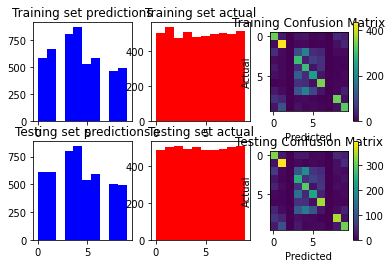

In [45]:
import gc
gc.collect()

Y_train_pred = cifar_net.forward(X_train[:5000]).detach().argmax(axis=1)
Y_test_pred = cifar_net.forward(X_test[:5000]).detach().argmax(axis=1)
show_performance(Y_train[:5000], Y_train_pred, Y_test[:5000], Y_test_pred)

In [27]:
print(X_train.element_size() * X_train.nelement())

614400000


In [29]:
X_train.nelement()

153600000

In [76]:
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            size = obj.element_size() * obj.nelement()
            if size>10000000:
                print(type(obj), size, obj.shape)
    except:
        pass

<class 'torch.Tensor'> 737280000 torch.Size([60000, 3, 32, 32])
<class 'torch.Tensor'> 614400000 torch.Size([50000, 3, 32, 32])
<class 'torch.Tensor'> 122880000 torch.Size([10000, 3, 32, 32])
<class 'torch.Tensor'> 61440000 torch.Size([5000, 3, 32, 32])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:101: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


In [75]:
gc.collect()

719